In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
from xgboost import plot_importance
from sklearn import metrics

In [2]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')
print(train_data)

       Unnamed: 0     id              date      speed             date1  \
0               0      0     1/1/2017 0:00  43.002930     2017/1/1 0:00   
1               1      1     1/1/2017 1:00  46.118696     2017/1/1 1:00   
2               2      2     1/1/2017 2:00  44.294158     2017/1/1 2:00   
3               3      3     1/1/2017 3:00  41.067468     2017/1/1 3:00   
4               4      4     1/1/2017 4:00  46.448653     2017/1/1 4:00   
...           ...    ...               ...        ...               ...   
14001       14001  14001  31/12/2018 12:00  19.865269  2018/12/31 12:00   
14002       14002  14002  31/12/2018 15:00  17.820375  2018/12/31 15:00   
14003       14003  14003  31/12/2018 16:00  12.501851  2018/12/31 16:00   
14004       14004  14004  31/12/2018 18:00  15.979319  2018/12/31 18:00   
14005       14005  14005  31/12/2018 20:00  40.594183  2018/12/31 20:00   

           t_date    t_time  holiday  daybefore  is_weekend  ...  temper  \
0        2017/1/1   0:0

In [3]:
# 确定要预测的特征变量（标签）
train_y = train_data.speed
# 要训练的特征列表
#predictor_cols = ['date']
# 要训练的真正的数据
train_X = train_data.date
for i in range(len(train_X)):
    train_X[i] = re.split(r'[;,\s/:]', train_X[i])
#    train_X[i] = re.sub('[\r\t:/]', '', train_X[i]).replace(" ", "")
print(train_X)
print(train_y)


C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0           [1, 1, 2017, 0, 00]
1           [1, 1, 2017, 1, 00]
2           [1, 1, 2017, 2, 00]
3           [1, 1, 2017, 3, 00]
4           [1, 1, 2017, 4, 00]
                  ...          
14001    [31, 12, 2018, 12, 00]
14002    [31, 12, 2018, 15, 00]
14003    [31, 12, 2018, 16, 00]
14004    [31, 12, 2018, 18, 00]
14005    [31, 12, 2018, 20, 00]
Name: date, Length: 14006, dtype: object
0        43.002930
1        46.118696
2        44.294158
3        41.067468
4        46.448653
           ...    
14001    19.865269
14002    17.820375
14003    12.501851
14004    15.979319
14005    40.594183
Name: speed, Length: 14006, dtype: float64


In [4]:
def judgeDay(day, mon, year):
    total_day = 0  # 周几
    week_day = 1  # 0是放假
    for i in range(int(mon)-1):
        total_day += month[i]
    total_day += day
    total_day = (total_day - (2018-year)) % 7
    
    if year == 2017:
        if mon == 1:
            if day == 2 or day == 28 or day == 30 or day == 31:
                week_day = 0
        if mon == 4:
            if day == 14 or day == 15 or day == 17:
                week_day = 0
        if mon == 5:
            if day == 1 or day == 3 or day == 30:
                week_day = 0
        if mon == 7:
            if day == 1:
                week_day = 0
        if mon == 10:
            if day == 2 or day == 5 or day == 28:
                week_day = 0
        if mon == 12:
            if day == 25 or day == 26:
                week_day = 0
    if year == 2018:
        if mon == 1:
            if day == 1:
                week_day = 0
        if mon == 2:
            if day == 16 or day == 17 or day == 19:
                week_day = 0
        if mon == 3:
            if day == 30 or day == 31:
                week_day = 0
        if mon == 4:
            if day == 2 or day == 5:
                week_day = 0
        if mon == 5:
            if day == 1 or day == 22:
                week_day = 0
        if mon == 6:
            if day == 18:
                week_day = 0
        if mon == 7:
            if day == 2:
                week_day = 0
        if mon == 9:
            if day == 25:
                week_day = 0
        if mon == 10:
            if day == 1 or day == 17:
                week_day = 0
        if mon == 12:
            if day == 25 or day == 26:
                week_day = 0
    if(total_day > 5 or total_day == 0): # total_day > 5 周六休息吗？
        week_day = 0
    
    return total_day, week_day



In [5]:
def judgeHour(time):
    if(time >= 8 and time <= 9) or (time >= 16 and time <= 19):
        return 0
    if(time >9 and time < 16):
        return 1
    else:
        return 2

In [6]:
features = pd.DataFrame(np.zeros([14006, 48]), columns=['day', 'month', 'year', 'hour', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun', 'hour0','hour1', 'hour2',
                          'hour3', 'hour4', 'hour5','hour6', 'hour7', 'hour8','hour9', 'hour10', 'hour11','hour12', 'hour13', 'hour14',
                          'hour15','hour16', 'hour17','hour18', 'hour19', 'hour20','hour21', 'hour22', 'hour23', 'dayoff', 'temper',
                         'wet', 'cloud', 'rain', 'wind', 'weekday', 'pressure',  'weather1', 'weather2', 'weather3'
                                                        , 'weather4', 'holiday'])

features['temper'] = train_data.temper
features['wet'] = train_data.wet
features['cloud'] = train_data.cloud
features['rain'] = train_data.rain
features['wind'] = train_data.wind
features['pressure'] = train_data.pressure
features['weather1'] = train_data.weather1
features['weather2'] = train_data.weather2
features['weather3'] = train_data.weather3
features['weather4'] = train_data.weather4
features['weather5'] = train_data.weather5
features['holiday'] = train_data.holiday

month = [31,28,31,30,31,30,31,31,30,31,30,31]
for i in range(14006):
    features['day'][i] = train_X[i][0]
    features['month'][i] = train_X[i][1]
    features['year'][i] = train_X[i][2]
    features['hour'][i] = train_X[i][3]
    total_day, week_day = judgeDay( features['day'][i], features['month'][i], features['year'][i])
    features['weekday'][i] = total_day
    if total_day == 1:
        features['Mon'][i] = 1
    if total_day == 2:
        features['Tue'][i] = 1
    if total_day == 3:
        features['Wed'][i] = 1
    if total_day == 4:
        features['Thur'][i] = 1
    if total_day == 5:
        features['Fri'][i] = 1
    if total_day == 6:
        features['Sat'][i] = 1
    if total_day == 7:
        features['Sun'][i] = 1
    features['dayoff'][i] = week_day
    hour = 'hour' + str(int(features['hour'][i]))
    features[hour][i] = 1
    

print(features)

C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:25: SettingWith

        day  month    year  hour  Mon  Tue  Wed  Thur  Fri  Sat  ...  rain  \
0       1.0    1.0  2017.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
1       1.0    1.0  2017.0   1.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
2       1.0    1.0  2017.0   2.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
3       1.0    1.0  2017.0   3.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
4       1.0    1.0  2017.0   4.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
...     ...    ...     ...   ...  ...  ...  ...   ...  ...  ...  ...   ...   
14001  31.0   12.0  2018.0  12.0  1.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
14002  31.0   12.0  2018.0  15.0  1.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
14003  31.0   12.0  2018.0  16.0  1.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
14004  31.0   12.0  2018.0  18.0  1.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   
14005  31.0   12.0  2018.0  20.0  1.0  0.0  0.0   0.0  0.0  0.0  ...   0.0   

       wind  weekday  pressure  weather1  weather2  weather3  w

In [12]:
train_list = pd.DataFrame(features, columns=['day', 'month', 'year', 'hour', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun',
                        'dayoff', 'temper', 'wet', 'cloud', 'rain', 'wind', 'weekday'])

x_train,x_test,y_train,y_test = train_test_split(train_list,train_y,test_size=0.25, random_state=41)

print(x_train.dtypes)

day        float64
month      float64
year       float64
hour       float64
Wed        float64
Thur       float64
Fri        float64
Sat        float64
Sun        float64
dayoff     float64
temper     float64
wet          int64
cloud        int64
rain       float64
wind       float64
weekday    float64
dtype: object


In [28]:
'''
# 网格搜索
xgb_model = xgb.XGBRegressor(nthread = 15)
cv_split = ShuffleSplit(n_splits=6, train_size=0.75, test_size=0.25)
param_grid = dict(
    max_depth = [4, 5, 6, 7, 8, 9, 10],
    learning_rate = [.01],
    n_estimators = range(1500, 1750, 500),
    subsample = [.90, .95, 1],
    min_child_weight = [4, 5, 6, 7, 8, 9, 10],
    colsample_bytree = [0.7, 0.8, 0.9],
    gamma = [0.1, 0.2, 0.5, 0.6],
    reg_alpha = [0.05, 0.1, 1, 2],
    reg_lambda = [0.05, 0.1, 1, 2]
)

# 创建模型
model = xgb.XGBRegressor()
grid = GridSearchCV(model, param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1,verbose=1)
grid.fit(train_list, train_y)
print(grid.best_params_, grid.best_score_)
'''
# model.fit(x_train,y_train)
# y_pred = model.predict(x_test)
# print('MSE为：',mean_squared_error(y_test,y_pred))

Fitting 6 folds for each of 4 candidates, totalling 24 fits
[19:52:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 1800, 'reg_alpha': 5, 'reg_lambda': 5, 'subsample': 0.9} -10.408857609014516


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.2min finished


In [40]:
# xgboost模型
model = xgb.XGBRegressor(n_estimators=380, learning_rate=.04, max_depth=9, subsample=.8, min_child_weight = 2, colsample_bytree = 1, gamma = 0.2, reg_alpha = 4, reg_lambda = 4)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE为：',mean_squared_error(y_test,y_pred), r2_score(y_test, y_pred))

[22:15:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE为： 10.612895670869458 0.9423303344877547


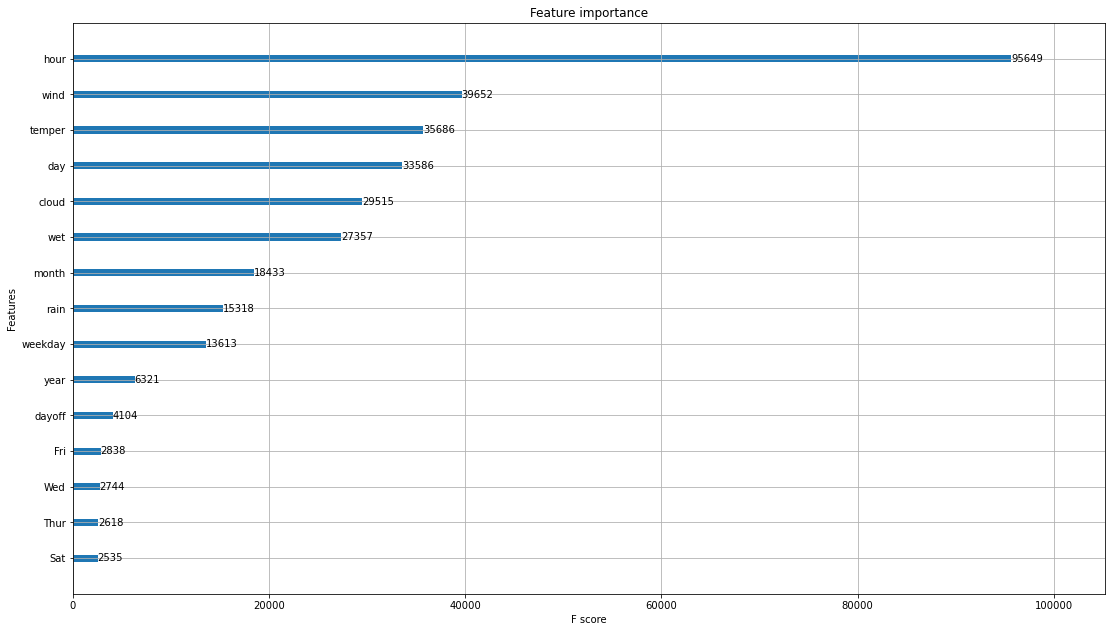

In [34]:
from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.show()

In [35]:
'''
# 随机森林
rf_model = RandomForestRegressor(n_estimators=1650)
# 把要训练的数据丢进去，进行模型训练
rf_model.fit(x_train,y_train)
y_pred = rf_model.predict(x_test)
print('MSE为：',mean_squared_error(y_test,y_pred))
'''

"\n# 随机森林\nrf_model = RandomForestRegressor(n_estimators=1650)\n# 把要训练的数据丢进去，进行模型训练\nrf_model.fit(x_train,y_train)\ny_pred = rf_model.predict(x_test)\nprint('MSE为：',mean_squared_error(y_test,y_pred))\n"

In [36]:
test_X = test_data.date
print(test_X)
for i in range(len(test_X)):
   test_X[i] = re.split(r'[;,\s/:]', test_X[i])

test_features = pd.DataFrame(np.zeros([3504, 42]), columns=['day', 'month', 'year', 'hour', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun', 'hour0','hour1', 'hour2',
                          'hour3', 'hour4', 'hour5','hour6', 'hour7', 'hour8','hour9', 'hour10', 'hour11','hour12', 'hour13', 'hour14',
                          'hour15','hour16', 'hour17','hour18', 'hour19', 'hour20','hour21', 'hour22', 'hour23', 'dayoff', 'temper',
                         'wet', 'cloud', 'rain', 'wind', 'weekday'])

test_features['temper'] = test_data.temper
test_features['wet'] = test_data.wet
test_features['cloud'] = test_data.cloud
test_features['rain'] = test_data.rain
test_features['wind'] = test_data.wind

for i in range(3504):
    test_features['day'][i] = test_X[i][0]
    test_features['month'][i] = test_X[i][1]
    test_features['year'][i] = test_X[i][2]
    test_features['hour'][i] = test_X[i][3]
    total_day, week_day = judgeDay(test_features['day'][i], test_features['month'][i], test_features['year'][i])
    test_features['weekday'][i] = total_day
    if total_day == 1:
        test_features['Mon'][i] = 1
    if total_day == 2:
        test_features['Tue'][i] = 1
    if total_day == 3:
        test_features['Wed'][i] = 1
    if total_day == 4:
        test_features['Thur'][i] = 1
    if total_day == 5:
        test_features['Fri'][i] = 1
    if total_day == 6:
        test_features['Sat'][i] = 1
    if total_day == 7:
        test_features['Sun'][i] = 1
    test_features['dayoff'][i] = week_day
    hour = 'hour' + str(int(test_features['hour'][i]))
    test_features[hour][i] = 1
    

print(test_features)

0          1/1/2018 2:00
1          1/1/2018 5:00
2          1/1/2018 7:00
3          1/1/2018 8:00
4         1/1/2018 10:00
              ...       
3499    31/12/2018 17:00
3500    31/12/2018 19:00
3501    31/12/2018 21:00
3502    31/12/2018 22:00
3503    31/12/2018 23:00
Name: date, Length: 3504, dtype: object
       day  month    year  hour  Mon  Tue  Wed  Thur  Fri  Sat  ...  hour21  \
0      1.0    1.0  2018.0   2.0  1.0  0.0  0.0   0.0  0.0  0.0  ...     0.0   
1      1.0    1.0  2018.0   5.0  1.0  0.0  0.0   0.0  0.0  0.0  ...     0.0   
2      1.0    1.0  2018.0   7.0  1.0  0.0  0.0   0.0  0.0  0.0  ...     0.0   
3      1.0    1.0  2018.0   8.0  1.0  0.0  0.0   0.0  0.0  0.0  ...     0.0   
4      1.0    1.0  2018.0  10.0  1.0  0.0  0.0   0.0  0.0  0.0  ...     0.0   
...    ...    ...     ...   ...  ...  ...  ...   ...  ...  ...  ...     ...   
3499  31.0   12.0  2018.0  17.0  1.0  0.0  0.0   0.0  0.0  0.0  ...     0.0   
3500  31.0   12.0  2018.0  19.0  1.0  0.0  0.0   0.0 

C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\snow\.conda\envs\bdt\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\snow\.conda\envs\bdt\lib\site-package

In [38]:
test_list = pd.DataFrame(test_features, columns=['day', 'month', 'year', 'hour', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun',
                        'dayoff', 'temper', 'wet', 'cloud', 'rain', 'wind', 'weekday'])

predicted_speed = model.predict(test_list)
print(predicted_speed)


[47.788166 47.65391  41.879524 ... 44.944237 38.96092  42.826923]


In [39]:
#把预测的值按照格式保存为csv文件'''
my_submission = pd.DataFrame({'id': test_data.id, 'speed': predicted_speed})
# you could use any filename. We choose submission here
my_submission.to_csv('submission32.csv', index=False)